# Binary classification of MRI images
#### AUTHOR: TOMASZ SACHANOWSKI

In [1]:
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
train_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/train_set/'
test_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/test_set/'
output_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/aug/'
model_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_3'
classes = ["orginal", "generated"]

## Characteristics of the images:
1) Two classes of objects with and without artifacts  
2) several planes of the brain's image  
3) Images with dimensions of 256x256 in a grayscale

## Presentation of images

<IPython.core.display.Javascript object>


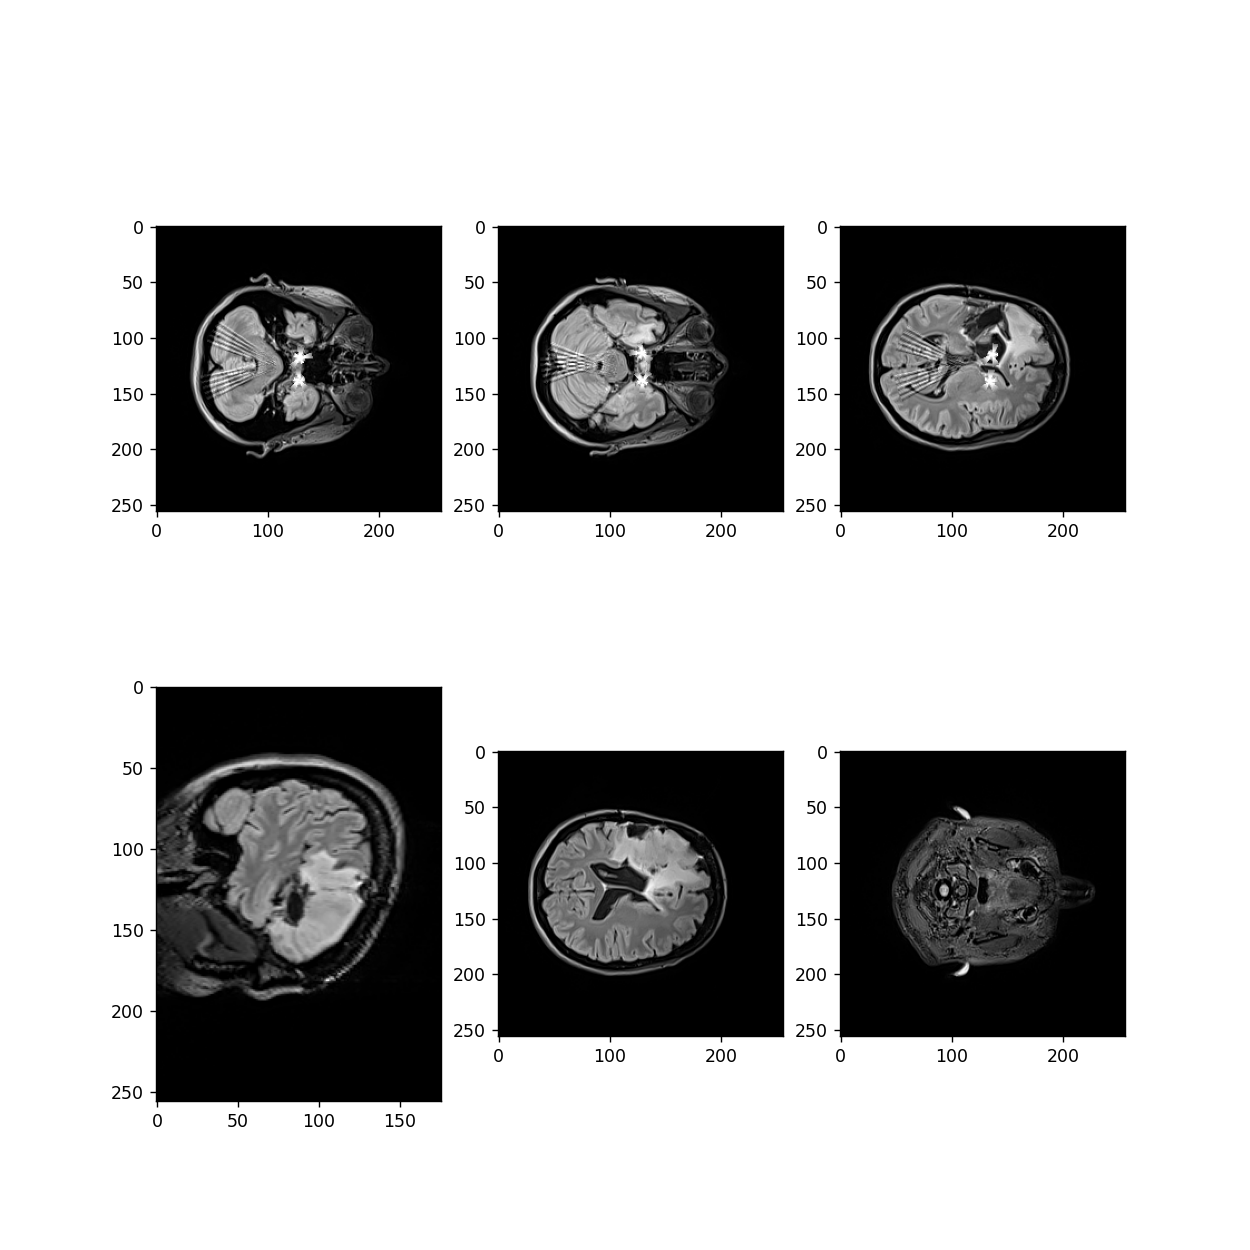

In [3]:
%matplotlib notebook
artifacts_images =['sub-001-image-46-2.png', 'sub-001-image-54-7.png', 'sub-001-image-85-8.png']
orginal_images = ['sub-001-A-image-8.png', 'sub-001-A-image-95.png', 'sub-001-B-image-79.png']
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    if i <= 3:
        img = mpimg.imread(os.path.join(train_dir +"/generated", artifacts_images[i-1]))
    else:
        img = mpimg.imread(os.path.join(train_dir +"/orginal", orginal_images[3-i]))

    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## GOAL
#### The goal is to successfully classify images. We would like to correctly indicate the images with the artifacts.

## Number of images available

In [4]:
len(os.listdir(test_dir+classes[0])), len(os.listdir(test_dir+classes[1]))

(75, 85)

In [5]:
len(os.listdir(train_dir+classes[0])), len(os.listdir(train_dir+classes[1]))

(722, 790)

## Data augmentation

In [6]:
gen_parameters = {
    "rotation_range":60,
    "zoom_range":0.2,
    "rescale":1./255,
    "horizontal_flip":True,
    "vertical_flip":True,
    "data_format":None,
    "dtype":None
}

In [7]:
flow_parameters ={
    "target_size":(256, 256),
    "color_mode":'grayscale',
    "class_mode":'binary',
    "batch_size":42,
}

In [8]:
# create Image generator for training and test set.
data_gen_train_val = ImageDataGenerator(**gen_parameters, validation_split=0.1)
data_gen_test = ImageDataGenerator(**gen_parameters)

In [9]:
train_generator = data_gen_train_val.flow_from_directory(
    train_dir, subset='training', **flow_parameters)

Found 1361 images belonging to 2 classes.


In [10]:
validation_generator = data_gen_train_val.flow_from_directory(
    train_dir, subset='validation', **flow_parameters)

Found 151 images belonging to 2 classes.


In [11]:
test_generator = data_gen_test.flow_from_directory(
    test_dir, **flow_parameters,
    save_to_dir=output_dir,
    save_format='png'
)

Found 160 images belonging to 2 classes.


In [12]:
class_names = train_generator.class_indices
class_names

{'generated': 0, 'orginal': 1}

## Build the convolutional neural network
### Here is where the convolution, pooling, and flattening layers will be applied
### `Conv2D` layer. It’s defined with the following parameters:
1) 32 output filters,  
2) 3 by 3 feature detector   
3) the `relu` activation function so as to achieve non-linearity 

### `MaxPooling2D` layer defined with the following parameters:
1) `pool_size` of (2, 2) that defines the size of the pooling window  

### That is followed by the `Flatten` layer whose results are passed to the `Dense` layer. The final layer has 1 units because the dataset has 2 classes. Since it’s a binary problem, the sigmoid activation function is applied.

### Reduce overfitting with Dropout. In this process, a specified percentage of connections are dropped during the training process

    `same` padding to result in even padding for the input  

2) 2 strides that define the number of steps taken by the pooling window 

In [13]:
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
#     Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
#    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

## Monitoring the validation loss and save the best model

In [14]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_dir + '/checkpoint',
    save_weights_only=False,
    monitor='val_loss', 
    mode='min', # mam loss wiec min
    save_best_only=True)

In [15]:
callbacks = [
             EarlyStopping(patience=5),
             model_checkpoint_callback,
]

## Compiling the model


In [16]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [17]:
history = model.fit(
    train_generator, validation_data=validation_generator,
    epochs=200, callbacks=callbacks)

Epoch 1/200


C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


33/33 [==============================] - 7s 183ms/step - loss: 0.5427 - binary_accuracy: 0.7149 - val_loss: 0.6478 - val_binary_accuracy: 0.6026
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_3\checkpoint\assets
Epoch 2/200
33/33 [==============================] - 6s 170ms/step - loss: 0.3287 - binary_accuracy: 0.8677 - val_loss: 0.5620 - val_binary_accuracy: 0.7086
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_3\checkpoint\assets
Epoch 3/200
33/33 [==============================] - 6s 169ms/step - loss: 0.2108 - binary_accuracy: 0.9192 - val_loss: 0.3867 - val_binary_accuracy: 0.8278
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_3\checkpoint\assets
Epoch 4/200
33/33 [==============================] - 6s 166ms/step - loss: 0.1573 - binary_accuracy: 0.9368 - val_loss: 0.5084 - val_binary_accuracy: 0.7351
Epoch 5/200
33/33 [=====

##  Visualize a deep learning model 

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 32)    320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
flatten (Flatten)            (None, None)              0

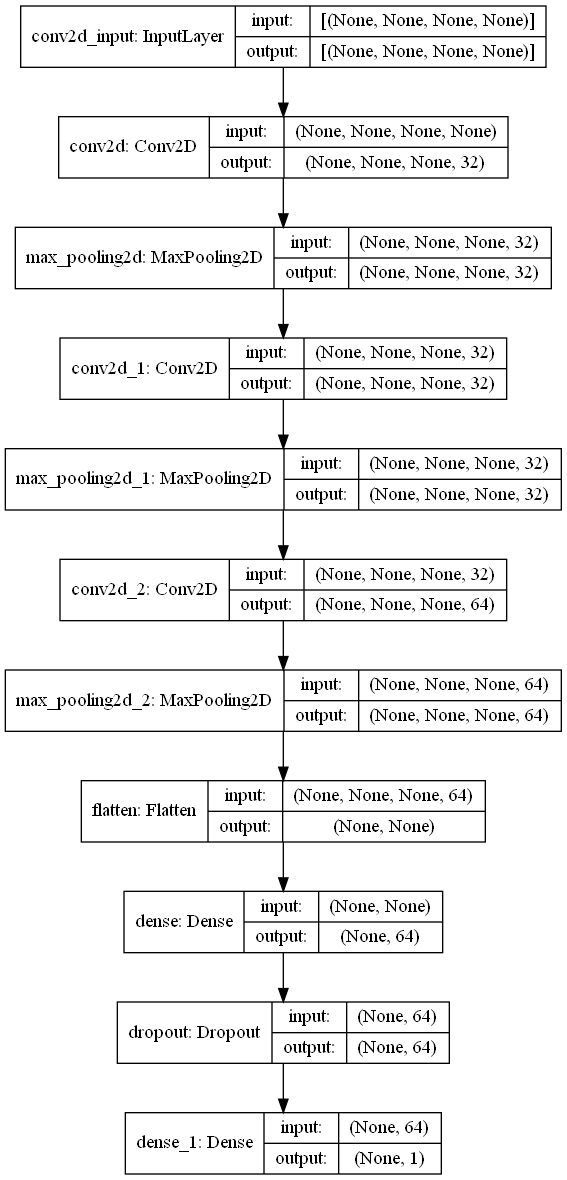

In [19]:
tf.keras.utils.plot_model(
    model,
    to_file=model_dir+ "/model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Monitoring the model’s performance


In [20]:
metrics_df = pd.DataFrame(history.history)

In [22]:
metrics_df

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.542707,0.714916,0.647800,0.602649
1,0.328684,0.867744,0.562035,0.708609
2,0.210821,0.919177,0.386690,0.827815
3,0.157254,0.936811,0.508418,0.735099
4,0.113002,0.963262,0.096850,0.973510
5,0.083653,0.970610,0.201458,0.880795
6,0.097982,0.959589,0.087174,0.960265
7,0.047718,0.986040,0.036957,1.000000
8,0.026398,0.995591,0.046581,0.980132
9,0.017868,0.993387,0.090930,0.960265


<IPython.core.display.Javascript object>


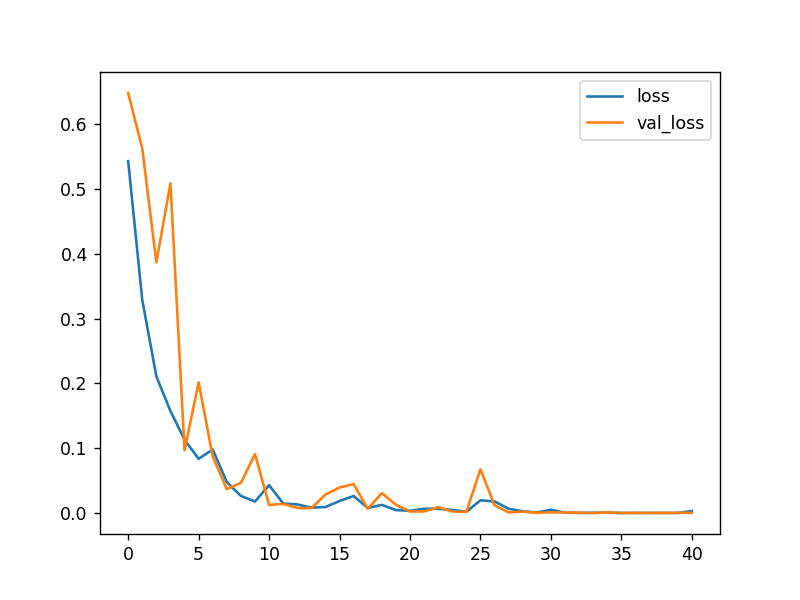

In [23]:
metrics_df[["loss","val_loss"]].plot();

<IPython.core.display.Javascript object>


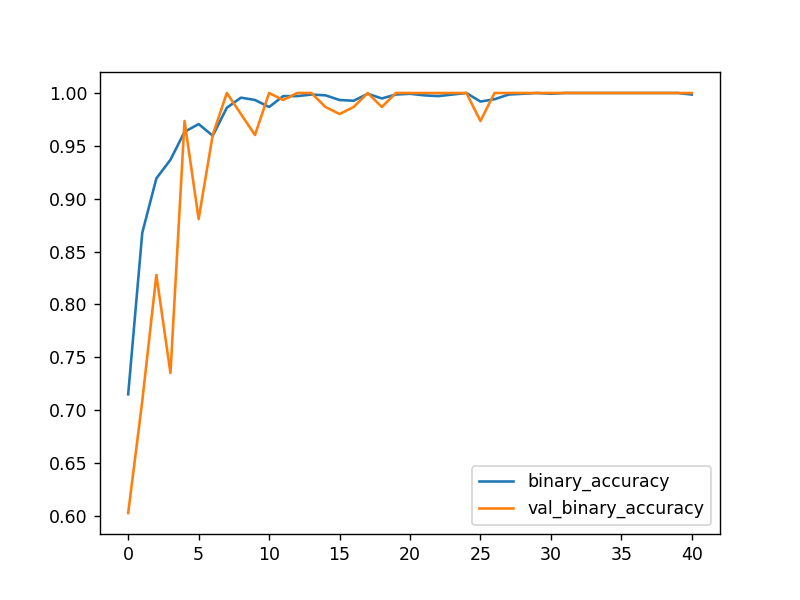

In [24]:
metrics_df[["binary_accuracy","val_binary_accuracy"]].plot();

## Checking the performance of the model on the validation set.

In [25]:
loss, accuracy = model.evaluate(validation_generator)

4/4 [==============================] - 1s 82ms/step - loss: 0.0237 - binary_accuracy: 0.9868


In [26]:
print('Accuracy on test dataset:', accuracy)

Accuracy on test dataset: 0.9867549538612366


In [34]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [35]:
good = 0
bad = 0
for name in os.listdir(test_dir +"/orginal"):
    print(name)
    test_image = image.load_img(
        os.path.join(test_dir +"/orginal", name), target_size=(256, 256),
        color_mode='grayscale')
    test_image = image.img_to_array(test_image)
    print(test_image.shape)

    img = mpimg.imread(os.path.join(test_dir +"/orginal", name))
#     plt.imshow(img)
#     plt.show()
    
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image)
    prediction[0][0]
    if prediction[0][0]>0.5:
        print(" is good")
        good = good + 1
    else:
        print(" is bad")
        bad = bad + 1

sub-001-A-image-112.png
(256, 256, 1)
 is bad
sub-001-A-image-120.png
(256, 256, 1)
 is bad
sub-001-A-image-137.png
(256, 256, 1)
 is bad
sub-001-A-image-16.png
(256, 256, 1)
 is bad
sub-001-A-image-19.png
(256, 256, 1)
 is bad
sub-001-A-image-25.png
(256, 256, 1)
 is bad
sub-001-A-image-34.png
(256, 256, 1)
 is bad
sub-001-A-image-43.png
(256, 256, 1)
 is bad
sub-001-A-image-49.png
(256, 256, 1)
 is bad
sub-001-A-image-69.png
(256, 256, 1)
 is bad
sub-001-A-image-7.png
(256, 256, 1)
 is bad
sub-001-B-image-136.png
(256, 256, 1)
 is good
sub-001-B-image-156.png
(256, 256, 1)
 is good
sub-001-B-image-161.png
(256, 256, 1)
 is good
sub-001-B-image-170.png
(256, 256, 1)
 is good
sub-001-B-image-181.png
(256, 256, 1)
 is good
sub-001-B-image-68.png
(256, 256, 1)
 is bad
sub-001-B-image-94.png
(256, 256, 1)
 is good
sub-001-C-image-112.png
(256, 256, 1)
 is good
sub-001-C-image-117.png
(256, 256, 1)
 is good
sub-001-C-image-119.png
(256, 256, 1)
 is good
sub-001-C-image-123.png
(256, 256, 1

In [36]:
good, bad

(26, 49)

In [37]:
good = 0
bad = 0
for name in os.listdir(test_dir +"/generated"):
    print(name)
    test_image = image.load_img(
        os.path.join(test_dir +"/generated", name), target_size=(256, 256),
        color_mode='grayscale')
    test_image = image.img_to_array(test_image)
    print(test_image.shape)

    img = mpimg.imread(os.path.join(test_dir +"/generated", name))
#     plt.imshow(img)
#     plt.show()
    
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image)
    prediction[0][0]
    if prediction[0][0]>0.5:
        print(" is good")
        good = good + 1
    else:
        print(" is bad")
        bad = bad + 1

sub-001-image-101-1.png
(256, 256, 1)
 is bad
sub-001-image-103-4 — kopia.png
(256, 256, 1)
 is bad
sub-001-image-104-2 — kopia.png
(256, 256, 1)
 is bad
sub-001-image-110-1.png
(256, 256, 1)
 is bad
sub-001-image-124-1.png
(256, 256, 1)
 is bad
sub-001-image-45-8.png
(256, 256, 1)
 is bad
sub-001-image-47-5.png
(256, 256, 1)
 is bad
sub-001-image-48-1 — kopia.png
(256, 256, 1)
 is bad
sub-001-image-53-2 — kopia.png
(256, 256, 1)
 is bad
sub-001-image-60-3.png
(256, 256, 1)
 is bad
sub-001-image-60-4 — kopia.png
(256, 256, 1)
 is bad
sub-001-image-60-5.png
(256, 256, 1)
 is bad
sub-001-image-61-1 — kopia.png
(256, 256, 1)
 is bad
sub-001-image-67-3 — kopia.png
(256, 256, 1)
 is bad
sub-001-image-75-1.png
(256, 256, 1)
 is bad
sub-001-image-80-5 — kopia.png
(256, 256, 1)
 is bad
sub-001-image-87-6.png
(256, 256, 1)
 is bad
sub-001-image-96-0 — kopia.png
(256, 256, 1)
 is bad
sub-001-image-97-1.png
(256, 256, 1)
 is bad
sub-001-image-99-3 — kopia.png
(256, 256, 1)
 is bad
sub-002-image-1

In [38]:
good, bad

(0, 85)

In [ ]:
import re

In [ ]:
for _ in range(100):
    img, label = test_generator.next()

In [ ]:
tp = 0
tn = 0
fp = 0
fn = 0
for name in os.listdir(output_dir):
    number = int(re.findall(r'^[^\d]*(\d+)', name)[0])
    test_image = image.load_img(
        os.path.join(output_dir, name), target_size=(256, 256),
        color_mode='grayscale')
    test_image = image.img_to_array(test_image)
    print(test_image.shape)

    img = mpimg.imread(os.path.join(output_dir, name))
    plt.imshow(img)
    plt.show()
    
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image)
    prediction[0][0]
    if prediction[0][0]>0.5:
        if number < len(os.listdir(test_dir+classes[0])):
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if number >= len(os.listdir(test_dir+classes[0])):
            tn = tn + 1
        else:
            fn = fn + 1

In [ ]:
good, bad

In [ ]:
prediction = model.predict(test_generator)


In [ ]:
good = [i for i,v in enumerate(prediction) if v >= 0.5]

In [ ]:
bad = [i for i,v in enumerate(prediction) if v < 0.5]

In [ ]:
for _ in range(5):
    img, label = test_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img)
    plt.show()

In [39]:
good = 0
bad = 0
for name in os.listdir(test_dir +"orginal"):
    test_image = image.load_img(
        os.path.join(test_dir +"orginal", name), target_size=(256, 256),
        color_mode='grayscale')
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image)
    prediction[0][0]
    if prediction[0][0]>0.5:
        good = good + 1
    else:
        bad = bad + 1
        

In [40]:

print("True positive: ", good, "\nFalse negative: ", bad)

True positive:  26 
False negative:  49


In [41]:
good = 0
bad = 0
for name in os.listdir(test_dir +"generated"):
    test_image = image.load_img(
        os.path.join(test_dir +"generated", name), target_size=(256, 256),
        color_mode='grayscale')
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image)
    prediction[0][0]
    if prediction[0][0]>0.5:
        good = good + 1
    else:
        bad = bad + 1
        

In [42]:
print("False positive: ", good, "\nTrue negative: ", bad)

False positive:  0 
True negative:  85


In [43]:
# for _ in range (100):
#     for images, labels in test_set.take(1):
#             print(int(labels[0]))
#             plt.imshow(images[0].numpy().astype("uint8"), cmap='gray')
#             plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict_generator(generator=test_generator,
                                steps=test_generator.samples//32,
                                max_queue_size=10,
                                workers=1,
                                use_multiprocessing=False,
                                verbose=0)

# Evaluate predictions
predictedClass = np.argmax(predictions, axis=1)
trueClass = test_generator.classes
classLabels = list(test_generator.class_indices.keys())

# Create confusion matrix
confusionMatrix = (confusion_matrix(
    y_true=trueClass,                                       # ground truth (correct) target values
    y_pred=predictedClass))                                 # estimated targets as returned by a classifier
print(confusionMatrix)

In [ ]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split


# prepare plots
fig, ax_roc = plt.subplots(1, 1, figsize=(11, 5))


RocCurveDisplay.from_predictions(y_true, y_predict, ax=ax_roc, name="CNN")
# DetCurveDisplay.from_predictions(y_true, y_predict, ax=ax_det, name="CNN")

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
# ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()